# Visualization of DensePose-COCO dataset

In this notebook, we visualize the DensePose-COCO annotations on the images.

The densepose COCO dataset annotations are provided within the coco annotation framework and can be handled directly using the pycocotools.

<br>
<div align="center">
  <img src="http://densepose.org/img/coords.png" width="400px" /><br>

   _Visualization of the partitioning of the surface and demonstration of "correspondence to a single point on a part"._
</div>


### DensePose fields in annotations:
#### Collected Masks
* **'dp_masks' :**  RLE encoded dense masks. All part masks are of size 256x256 and maps to 14 labels. Please note that these are not linked to the 3D template. These are semantically meaningful parts collected from annotators, we use these to sample annotation points.

#### Collected Points
* **'dp_x'**, **'dp_y' :**  The spatial coordinates of collected points on the image. The coordinates are scaled such that the bounding box size is 256x256.
* **'dp_I' :**  The patch index that indicates which of the 24 surface patches the point is on.
* **'dp_U'**, **'dp_V' :**  Coordinates in the UV space. Each surface patch has a separate 2D parameterization.

In the following, we reshape the collected masks and points 


In [ ]:
from pycocotools.coco import COCO
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
from random import randint

coco_folder = '/content/drive/MyDrive/DensePose-master/detectron/datasets/data/coco/'
dp_coco = COCO( coco_folder + '/annotations/densepose_coco_2014_minival.json')
#dp_coco = COCO('densepose_coco_2014_minival.json')

loading annotations into memory...
Done (t=4.36s)
creating index...
index created!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Select a random image, read it and load the annotations that correspond to this image.

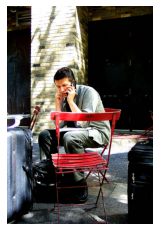

In [ ]:
# Get img id's for the minival dataset.
im_ids = dp_coco.getImgIds()
# Select a random image id.
Selected_im = im_ids[randint(0, len(im_ids))] # Choose im no 57 to replicate 
# Load the image
im = dp_coco.loadImgs(Selected_im)[0]  
# Load Anns for the selected image.
ann_ids = dp_coco.getAnnIds( imgIds=im['id'] )
anns = dp_coco.loadAnns(ann_ids)
# Now read and b
im_name = os.path.join( coco_folder + '/val2014', im['file_name'] )
I=cv2.imread(im_name)
plt.imshow(I[:,:,::-1]); plt.axis('off'); plt.show()

## Visualization of Collected Masks

Let's visualize the collected masks on the image. 

These masks are used:
* to sample points to collect dense correspondences.
* as an auxillary loss in DensePose-RCNN.
* to obtain dense FG/BG maps.

A function to get dense masks from the decoded masks.


In [ ]:
def GetDensePoseMask(Polys):
    MaskGen = np.zeros([256,256])
    for i in range(1,15):
        if(Polys[i-1]):
            current_mask = mask_util.decode(Polys[i-1])
            MaskGen[current_mask>0] = i
    return MaskGen

Go over all anns and visualize them one by one.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


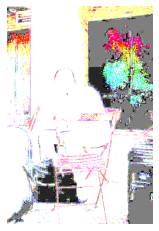

In [ ]:
I_vis=I.copy()/2 # Dim the image.

for ann in anns:  
    bbr =  np.array(ann['bbox']).astype(int) # the box.
    if( 'dp_masks' in ann.keys()): # If we have densepose annotation for this ann, 
        Mask = GetDensePoseMask(ann['dp_masks'])
        ################
        x1,y1,x2,y2 = bbr[0],bbr[1],bbr[0]+bbr[2],bbr[1]+bbr[3]
        x2 = min( [ x2,I.shape[1] ] );  y2 = min( [ y2,I.shape[0] ] )
        ################ 
        MaskIm = cv2.resize( Mask, (int(x2-x1),int(y2-y1)) ,interpolation=cv2.INTER_NEAREST)
        MaskBool = np.tile((MaskIm==0)[:,:,np.newaxis],[1,1,3])
        #  Replace the visualized mask image with I_vis.
        Mask_vis = cv2.applyColorMap( (MaskIm*15).astype(np.uint8) , cv2.COLORMAP_PARULA)[:,:,:]
        Mask_vis[MaskBool]=I_vis[y1:y2,x1:x2,:][MaskBool]
        I_vis[y1:y2,x1:x2,:] = I_vis[y1:y2,x1:x2,:]*0.3 + Mask_vis*0.7

plt.imshow(I_vis[:,:,::-1]); plt.axis('off'); plt.show()

## Visualization of Collected points

Let's visualize the collected points on the image. 

For each collected point we have the surface patch index, and UV coordinates.

The following snippet creates plots colored by I U and V coordinates respectively.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile

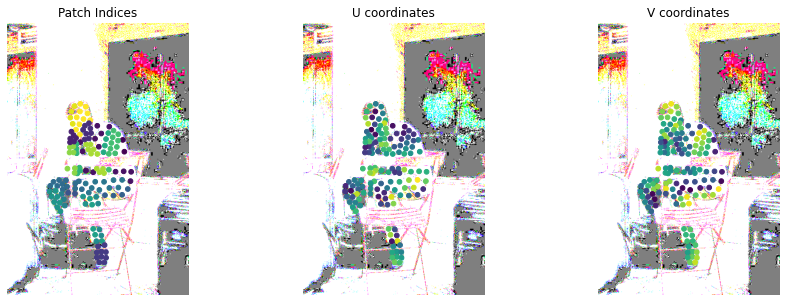

In [ ]:
# Show images for each subplot.
fig = plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.imshow(I[:,:,::-1]/2);plt.axis('off');plt.title('Patch Indices')
plt.subplot(1,3,2)
plt.imshow(I[:,:,::-1]/2);plt.axis('off');plt.title('U coordinates')
plt.subplot(1,3,3)
plt.imshow(I[:,:,::-1]/2);plt.axis('off');plt.title('V coordinates')

## For each ann, scatter plot the collected points.
for ann in anns:
    bbr =  np.round(ann['bbox']) 
    if( 'dp_masks' in ann.keys()):
        Point_x = np.array(ann['dp_x'])/ 255. * bbr[2] # Strech the points to current box.
        Point_y = np.array(ann['dp_y'])/ 255. * bbr[3] # Strech the points to current box.
        #
        Point_I = np.array(ann['dp_I'])
        Point_U = np.array(ann['dp_U'])
        Point_V = np.array(ann['dp_V'])
        #
        x1,y1,x2,y2 = bbr[0],bbr[1],bbr[0]+bbr[2],bbr[1]+bbr[3]
        x2 = min( [ x2,I.shape[1] ] ); y2 = min( [ y2,I.shape[0] ] )
        ###############
        Point_x = Point_x + x1 ; Point_y = Point_y + y1
        plt.subplot(1,3,1)
        plt.scatter(Point_x,Point_y,22,Point_I)
        plt.subplot(1,3,2)
        plt.scatter(Point_x,Point_y,22,Point_U)
        plt.subplot(1,3,3)
        plt.scatter(Point_x,Point_y,22,Point_V)
        
plt.show()